# Ultralytics Classifier

Set up runtime to use GPU

## Create or get the dataset

In [ ]:
# https://www.mvtec.com/company/research/datasets/mvtec-ad/downloads
# Get bottle dataset
!wget https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937370-1629951468/bottle.tar.xz

In [2]:
!tar -xf bottle.tar.xz

In [3]:
# Create a filename_ok list
import os
from PIL import Image
import cv2
folder_ok = os.path.join("bottle","train","good")
filename_ok = []
for name in sorted(os.listdir(folder_ok)):
    filename = os.path.join(folder_ok, name)
    filename_ok.append(filename)
    #im = cv2.imread(filename, cv2.IMREAD_COLOR)
    #im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    #display(Image.fromarray(im).resize((256,256)))
    #break

In [4]:
# Create a filename_nok list
import os
from PIL import Image
import cv2
folders_nok = ["broken_large","broken_small","contamination"]
filename_nok = []
for folder in folders_nok:
    folder_nok = os.path.join("bottle","test", folder)
    for name in sorted(os.listdir(folder_nok)):
        filename = os.path.join(folder_nok, name)
        filename_nok.append(filename)
        #im = cv2.imread(filename, cv2.IMREAD_COLOR)
        #im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        #display(Image.fromarray(im).resize((256,256)))
        #break

In [5]:
# Print  number of data
print(f"NOK: {len(filename_nok)}")
print(f"OK: {len(filename_ok)}")

NOK: 63
OK: 209


In [8]:
# Be sure to have same number of ok and nok, we select 40 each
import random
num = 40
f_nok = random.sample(filename_nok, num)
f_ok = random.sample(filename_ok, num)

In [9]:
# Split into train test val
def split_train_test_val(filenames, train_pct, test_pct, val_pct):
    # Calculate split indices
    total_files = len(filenames)
    split_train = int(train_pct * total_files)
    split_val = split_train + int(val_pct * total_files)

    # Split filenames
    train_filenames = filenames[:split_train]
    val_filenames = filenames[split_train:split_val]
    test_filenames = filenames[split_val:]
    return train_filenames, val_filenames, test_filenames

f_ok_train, f_ok_val, f_ok_test = split_train_test_val(f_ok, 0.8,0.1,0.1)
f_nok_train, f_nok_val, f_nok_test = split_train_test_val(f_nok, 0.8,0.1,0.1)


In [10]:
# Create the dataset
import shutil
dataset ="/content/dataset"
if os.path.exists(dataset):
    shutil.rmtree(dataset)
os.makedirs(dataset)

def write_images(f_data, folder_dataset):
    if not os.path.exists(folder_dataset):
        os.makedirs(folder_dataset)
    for f in f_data:
        im = cv2.imread(f, cv2.IMREAD_COLOR)
        fout_train = os.path.join(folder_dataset, f"{f.split('/')[-2]}_{f.split('/')[-1]}")
        cv2.imwrite( fout_train, im)

write_images(f_ok_train, os.path.join(dataset, "train", "ok"))
write_images(f_nok_train, os.path.join(dataset, "train", "nok"))

write_images(f_ok_val, os.path.join(dataset, "val", "ok"))
write_images(f_nok_val, os.path.join(dataset, "val", "nok"))

write_images(f_ok_test, os.path.join(dataset, "test", "ok"))
write_images(f_nok_test, os.path.join(dataset, "test", "nok"))



## Training

In [11]:
# Create training config file
import yaml
labels_name = ["ok","nok"]
data = {
    "train": f"{dataset}/train",
    "val":   f"{dataset}/val",
    "test":  f"{dataset}/test",
    "nc": len(labels_name),
    "names": labels_name,
}
# Create and write to the YAML file
yaml_file_path = "dataset/data.yaml"
with open(yaml_file_path, 'w') as file:
    yaml.dump(data, file, sort_keys=False)


In [ ]:
# Install ultralytics
!pip install ultralytics

In [13]:
# remove dataset if available. Each training has to be unique
!rm -rf tmp_training

In [14]:
# train
from ultralytics import YOLO
model = YOLO("yolov8n-cls.pt", task="classify")
results = model.train(data="/content/dataset", epochs=30, imgsz=640,batch=4, project="/content/tmp_training")


100%|██████████| 5.30M/5.30M [00:00<00:00, 68.7MB/s]


Ultralytics YOLOv8.1.11 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/content/dataset, epochs=30, time=None, patience=50, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/tmp_training, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

100%|██████████| 6.23M/6.23M [00:00<00:00, 77.1MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/train... 64 images, 0 corrupt: 100%|██████████| 64/64 [00:00<00:00, 724.84it/s]

train: New cache created: /content/dataset/train.cache



val: Scanning /content/dataset/val... 8 images, 0 corrupt: 100%|██████████| 8/8 [00:00<00:00, 497.63it/s]

val: New cache created: /content/dataset/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/tmp_training/train
Starting training for 30 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/30     0.677G     0.7272          4        640:  25%|██▌       | 4/16 [00:01<00:03,  3.52it/s]

       1/30     0.679G     0.7226          4        640:  56%|█████▋    | 9/16 [00:03<00:02,  3.17it/s]
100%|██████████| 755k/755k [00:00<00:00, 15.1MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all        0.5          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 23.92it/s]

                   all      0.875          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 32.65it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 15.05it/s]

                   all      0.875          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 31.30it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 19.07it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 28.57it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 26.17it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 40.38it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      10/30     0.671G     0.5112          4        640: 100%|██████████| 16/16 [00:02<00:00,  6.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      11/30     0.671G     0.4492          4        640: 100%|██████████| 16/16 [00:02<00:00,  5.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 22.78it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      12/30     0.671G     0.4532          4        640: 100%|██████████| 16/16 [00:02<00:00,  7.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 35.48it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      13/30     0.671G     0.3938          4        640: 100%|██████████| 16/16 [00:02<00:00,  7.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 39.65it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      14/30     0.671G     0.4594          4        640: 100%|██████████| 16/16 [00:02<00:00,  5.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 28.28it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      15/30     0.671G     0.4188          4        640: 100%|██████████| 16/16 [00:02<00:00,  6.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 48.88it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      16/30     0.671G     0.3663          4        640: 100%|██████████| 16/16 [00:02<00:00,  6.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 42.27it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      17/30     0.671G     0.3015          4        640: 100%|██████████| 16/16 [00:02<00:00,  7.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 32.14it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      18/30     0.671G     0.4059          4        640: 100%|██████████| 16/16 [00:03<00:00,  4.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 38.40it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      19/30     0.671G      0.337          4        640: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 38.51it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      20/30     0.671G     0.2364          4        640: 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 22.91it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      21/30     0.671G     0.3736          4        640: 100%|██████████| 16/16 [00:03<00:00,  4.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 21.99it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      22/30     0.671G      0.412          4        640: 100%|██████████| 16/16 [00:02<00:00,  5.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 32.84it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      23/30     0.671G     0.4136          4        640: 100%|██████████| 16/16 [00:02<00:00,  6.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 43.63it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      24/30     0.671G     0.3208          4        640: 100%|██████████| 16/16 [00:02<00:00,  6.58it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 25.29it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      25/30     0.671G     0.2944          4        640: 100%|██████████| 16/16 [00:03<00:00,  4.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 41.72it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      26/30     0.671G      0.262          4        640: 100%|██████████| 16/16 [00:02<00:00,  6.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 19.36it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      27/30     0.671G     0.4597          4        640: 100%|██████████| 16/16 [00:02<00:00,  6.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 22.10it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      28/30     0.671G     0.3412          4        640: 100%|██████████| 16/16 [00:03<00:00,  4.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 27.83it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      29/30     0.671G     0.2596          4        640: 100%|██████████| 16/16 [00:02<00:00,  6.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 24.12it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      30/30     0.671G     0.2755          4        640: 100%|██████████| 16/16 [00:02<00:00,  6.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 18.62it/s]

                   all          1          1



30 epochs completed in 0.032 hours.
Optimizer stripped from /content/tmp_training/train/weights/last.pt, 3.0MB
Optimizer stripped from /content/tmp_training/train/weights/best.pt, 3.0MB

Validating /content/tmp_training/train/weights/best.pt...
Ultralytics YOLOv8.1.11 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1437442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/dataset/train... found 64 images in 2 classes ✅ 
val: /content/dataset/val... found 8 images in 2 classes ✅ 
test: /content/dataset/test... found 8 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


                   all          1          1
Speed: 0.5ms preprocess, 1.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/tmp_training/train
Results saved to /content/tmp_training/train


## Inference Pipeline: Test the model

In [15]:
import torch
import numpy as np

class Yolov8Inference:
    def __init__(self, model_path, gpu=False):
        self.model = YOLO(model_path)
        self.device = torch.device("cpu")
        if gpu:
            if torch.cuda.is_available():
                self.device = torch.device("cuda")
                print(f"Model will run on GPU: {torch.cuda.get_device_name(0)}")
            else:
                print("Model will run on CPU, because GPU is not available")
        else:
            print("Model will run on CPU")
        self.labels = self.model.names

    def predict(self, im):

        # im has to be numpy array
        # start = time.time()
        res = self.model.predict(im, imgsz=640, device=self.device, conf=0.01, iou=0.01, verbose=False)
        # end = time.time()
        # print(f"Model inference: {end-start:2f}s")

        #print(res[0].probs)
        names = res[0].names
        scores = res[0].probs.data.cpu().numpy()

        im_draw = im.copy()
        idx = np.argmax(scores)
        score = scores[idx]
        cv2.putText(im_draw, f"{names[idx]}: {score:.2f}", (30, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.5,(0, 0, 255), 1)

        return im_draw



Model will run on CPU


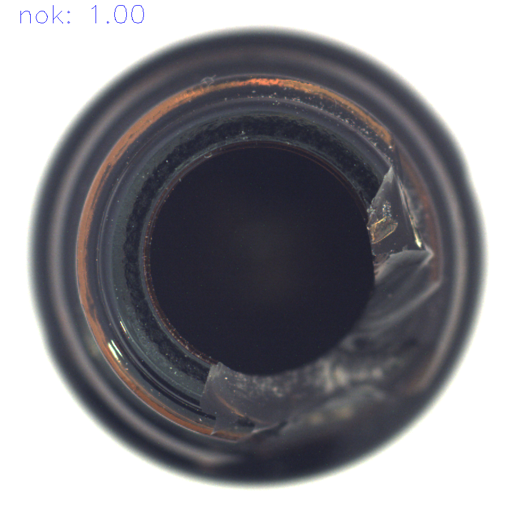

In [18]:
model = Yolov8Inference("/content/tmp_training/train/weights/best.pt")
for f in filename_nok:
    im = cv2.imread(f, cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im_draw = model.predict(im)
    display(Image.fromarray(im_draw).resize((512,512)))
    break